In [1]:
from nufeb_tools import utils,plot
from scipy.integrate import odeint
import numpy as np
import pandas as pd
from itertools import combinations
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.optimize import curve_fit

In [2]:
x = utils.get_data(test=True)
#x.single_cell_growth()


In [3]:
df = x.get_positions()
df

,ID,type,x,y,z
0,95,2,0.000026,0.000020,0.000001
1,53,2,0.000024,0.000004,0.000003
2,62,2,0.000042,0.000006,0.000003
3,45,2,0.000027,0.000016,0.000003
4,26,1,0.000035,0.000003,0.000004
...,...,...,...,...,...
111,3,1,0.000096,0.000088,0.000006
112,110,2,0.000094,0.000093,0.000007
113,1,1,0.000053,0.000096,0.000008
114,89,2,0.000079,0.000090,0.000008


In [4]:

x.h5['type']['0'].__array__()

array([2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1,
       1, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 1, 1, 1, 2,
       1, 2, 1, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 2, 1, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2,
       2, 1, 2, 1, 2, 2])

In [4]:

neigh = x.get_neighbor_distance(45,10000)
neigh

,ID,type,Distance
0,211,2,0.000005
1,649,2,0.000005
2,388,2,0.000004
3,376,2,0.000005
4,650,2,0.000013
...,...,...,...
684,491,2,0.000090
685,590,2,0.000087
686,330,2,0.000087
687,532,2,0.000090


<AxesSubplot:xlabel='ID', ylabel='Distance'>

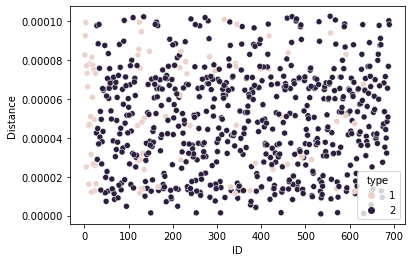

In [5]:
sns.scatterplot(data=neigh,x='ID',y='Distance',hue='type')

In [7]:
""" light = 1.00e-01 #kg/m^3
co2 = 4e-1
mu_max = 0.047*24 #2.25e-05# 1/d
K_m_light = 3.5e-04
K_m_co2 = 5e-2
def monod_func(y,t):
    return y*mu_max * (light/(K_m_light + light)) * (co2/( K_m_co2 + co2))
t = np.linspace(df.index[0], df.index[-1],1000)
sol = odeint(monod_func, y0, t)
f, ax = plt.subplots(figsize=(9,6))
ax.plot(df.iloc[:,1],label=f'Data')
ax.plot(t,sol,ls='--',label=f'fit') """

" light = 1.00e-01 #kg/m^3\nco2 = 4e-1\nmu_max = 0.047*24 #2.25e-05# 1/d\nK_m_light = 3.5e-04\nK_m_co2 = 5e-2\ndef monod_func(y,t):\n    return y*mu_max * (light/(K_m_light + light)) * (co2/( K_m_co2 + co2))\nt = np.linspace(df.index[0], df.index[-1],1000)\nsol = odeint(monod_func, y0, t)\nf, ax = plt.subplots(figsize=(9,6))\nax.plot(df.iloc[:,1],label=f'Data')\nax.plot(t,sol,ls='--',label=f'fit') "

In [7]:
x.get_local_con('suc',0,1)

3.42e-20

In [8]:
help(x.get_local_con)

Help on method get_local_con in module nufeb_tools.utils:

get_local_con(nutrient, timestep, cellID) method of nufeb_tools.utils.get_data instance
    Get the local nutrient concentration of a cell
    
    Args:
        nutrient (str):
            The nutrient to check the concentration of
        timestep (int):
            The timestep at which to check the concentration
        cellID (int):
            The cell identification number
    
    Returns:
        Nutrient Concentration (float):
            The concentration of the specified nutrient within the cell's grid



In [10]:
utils.get_grid_idx(grid_loc[1],cl[1])

NameError: name 'grid_loc' is not defined

In [18]:
x.get_local_con('suc',10000,1)

0.8104361259742746

In [26]:
for item in x.h5['concentration'].__iter__():
    print(item)

co2
o2
sub
suc


In [28]:
x.h5['concentration'].__contains__('Sucrose')

False

In [34]:
nutes = list(x.h5['concentration'].__iter__())

In [35]:
nutes

['co2', 'o2', 'sub', 'suc']

In [43]:
print(*nutes),print('1')

co2 o2 sub suc
1


(None, None)

In [ ]:
x.metadata['Dimensions']

[0.0001, 0.0001, 1e-05]

In [ ]:
l = list(x.dims)

In [ ]:
l += [l.pop(0)]

In [ ]:
l

[50, 5, 50]

In [ ]:
grid = [np.linspace(0,x.metadata['Dimensions'][i],l[i]) for i in range(3)]

In [ ]:
grid

[array([0.00000000e+00, 2.04081633e-06, 4.08163265e-06, 6.12244898e-06,
        8.16326531e-06, 1.02040816e-05, 1.22448980e-05, 1.42857143e-05,
        1.63265306e-05, 1.83673469e-05, 2.04081633e-05, 2.24489796e-05,
        2.44897959e-05, 2.65306122e-05, 2.85714286e-05, 3.06122449e-05,
        3.26530612e-05, 3.46938776e-05, 3.67346939e-05, 3.87755102e-05,
        4.08163265e-05, 4.28571429e-05, 4.48979592e-05, 4.69387755e-05,
        4.89795918e-05, 5.10204082e-05, 5.30612245e-05, 5.51020408e-05,
        5.71428571e-05, 5.91836735e-05, 6.12244898e-05, 6.32653061e-05,
        6.53061224e-05, 6.73469388e-05, 6.93877551e-05, 7.14285714e-05,
        7.34693878e-05, 7.55102041e-05, 7.75510204e-05, 7.95918367e-05,
        8.16326531e-05, 8.36734694e-05, 8.57142857e-05, 8.77551020e-05,
        8.97959184e-05, 9.18367347e-05, 9.38775510e-05, 9.59183673e-05,
        9.79591837e-05, 1.00000000e-04]),
 array([0.0e+00, 2.5e-05, 5.0e-05, 7.5e-05, 1.0e-04]),
 array([0.00000000e+00, 2.04081633e-07,

In [ ]:
ret_array[ret_array.ID ==95]['x'].values[0]

2.59e-05

In [ ]:
ret_array.loc[0]['x']

2.59e-05

In [ ]:
def get_grid_idx(array,value):
    """
    Find the nutrient grid index value. Taken from https://stackoverflow.com/questions/2566412/find-nearest-value-in-numpy-array.

    Args:
        array (numpy.array):
            1D Array containing the grid positions
        value (float):
            Cell location to map to the grid
    Returns:
        index (int):
            Grid index
    """
    n = len(array)

    jl = 0# Initialize lower
    ju = n-1# and upper limits.
    while (ju-jl > 1):# If we are not yet done,
        jm=(ju+jl) >> 1# compute a midpoint with a bitshift
        if (value >= array[jm]):
            jl=jm# and replace either the lower limit
        else:
            ju=jm# or the upper limit, as appropriate.
        # Repeat until the test condition is satisfied.
    if (value == array[0]):# edge cases at bottom
        return 0
    elif (value == array[n-1]):# and top
        return n-1
    else:
        return jl

In [ ]:
get_grid_idx(grid_loc[1],cl[1])

47

In [ ]:
grid[0][12]

2.448979591836735e-05

In [ ]:
trajectory['concentration']['suc']['1000'][0,12,0]

0.12523104535199808

In [ ]:
grid = [np.linspace(0,metadata['Dimensions'][x],l[x]) for x in range(3)]
grid_loc = [get_grid_idx(grid[i],ret_array[ret_array.ID ==95][d].values[0]) for i,d in enumerate(['x','y','z'])]

In [ ]:
grid_loc

[12, 9, 0]

In [ ]:
trajectory['concentration']['suc']['1000'][grid_loc[2],grid_loc[0],grid_loc[1]]

0.1326231307024827

In [ ]:
def get_local_con(trajectory,nutrient,timestep,cellID):
    grid = [np.linspace(0,metadata['Dimensions'][x],l[x]) for x in range(3)]
    grid_loc = [get_grid_idx(grid[i],ret_array[ret_array.ID ==cellID][d].values[0]) for i,d in enumerate(['x','y','z'])]
    return trajectory['concentration'][nutrient][str(timestep)][grid_loc[2],grid_loc[0],grid_loc[1]]

In [ ]:
get_local_con(trajectory,'suc',0,1)

3.42e-20

In [ ]:
timepoints = [key for key in trajectory['concentration']['co2'].keys()]
timepoints.sort(key=int)

In [ ]:
df = x.single_cell_biomass
#df = df[df.id == 95]
df


,id,type,time,biomass
0,95,2,0.000000,92.505631
1,95,2,0.277778,90.662882
2,95,2,0.555556,88.941568
3,95,2,0.833333,87.342844
4,95,2,1.111111,85.860407
...,...,...,...,...
11711,79,2,26.666667,132.590902
11712,79,2,26.944444,136.687773
11713,79,2,27.222222,140.810091
11714,79,2,27.500000,67.292851


In [ ]:
light = 1.00e-01 #kg/m^3
co2 = 4e-1
mu_max_cy = 0.06
K_m_light = 3.5e-04
K_m_co2 = 5e-2
K_m_suc = 3.6
K_m_o2 = 0.001
mu_max_ecw = 0.972
o2 = 0.009
suc = 0.1
df.type.unique()[0]

1

In [ ]:
#[get_local_con(trajectory,'suc',t,1) for t in timepoints]

In [ ]:
x= utils.get_data(id='c/47146695')
x.single_cell_growth()
df = x.single_cell_biomass


NameError: name 'x' is not defined